In [ ]:
import os
root_folder = 'malimg_paper_dataset_imgs'
families = os.listdir(root_folder)
families.remove('.DS_Store') # there was some artifact called .DS_Store idk how it is being created
families.sort()
meta_training_family = ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.gen!g', 'Lolyda.AA2', 'Lolyda.AT',
                        'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']
meta_testing_family = ['Dialplatform.B', 'Allaple.L', 'C2LOP.P', 'Lolyda.AA1', 'Malex.gen!J']
meta_validation_family = ['Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA3', 'Obfuscator.AD']
print(len(meta_training_family), len(meta_testing_family), len(meta_validation_family))

25
['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']
15 5 5


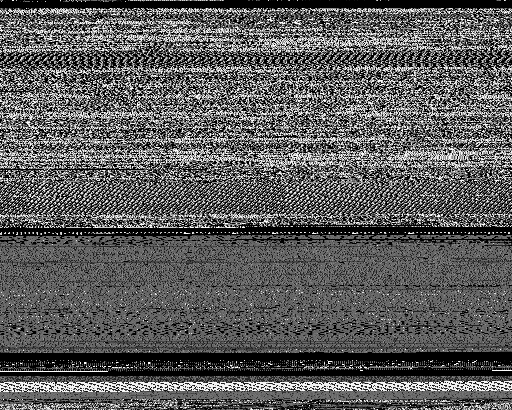

PNG (512, 410) L


In [17]:
from PIL import Image
test_img = os.path.join(root_folder,'Adialer.C/00bb6b6a7be5402fcfce453630bfff19.png')
im = Image.open(test_img)
display(im)
print(im.format, im.size, im.mode)

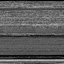

None (64, 64) L
4096


In [25]:
from PIL.Image import Resampling
import numpy as np
resize = im.resize(size=[64,64], resample=Resampling.LANCZOS)
display(resize)
print(resize.format, resize.size, resize.mode)
print(np.array(resize).size)

In [ ]:
import random
print(resize.format, resize.size, resize.mode)
numpy_resized = np.array(resize).ravel()
print(numpy_resized[4095])
num_slices = random.choice([1,2,3,4,5]) # determines at how many locations we will insert redundant code
indices = np.arange(len(numpy_resized))
print(indices)
cut_points = random.sample(list(indices), num_slices)# it will give the indices where we will insert the code
slice_length = random.choice(np.arange(40,400,1))
print(slice_length)


None (64, 64) L
134
[   0    1    2 ... 4093 4094 4095]
42


# Resizing all images in gray scale

- `[Original Large Image]` -> `Resize #1 (Standardization)` -> `[Clean 64x64 Image]` 
- Then, during training for each sample:

    - `[Clean 64x64 Image]` -> `Insertion/Duplication Augmentation (which includes Resize #2)` -> `[Final Augmented 64x64 Image]`

In [32]:
# -- Basic Resizing code --
from PIL import Image
from PIL.Image import Resampling
import os
from tqdm import tqdm

class ImageResizerBase:
    def __init__(self, src_root, dst_root, size=(64,64), resampler=Resampling.LANCZOS):
        self.src_root = src_root
        self.dst_root = dst_root
        self.size = size
        self.resample = resampler

    def resize_all(self, families):
        for family in tqdm(families, desc='families'):
            src_family_dir = os.path.join(self.src_root, family)
            dst_family_dir = os.path.join(self.dst_root, family)
            os.makedirs(dst_family_dir, exist_ok=True)
            images = os.listdir(src_family_dir)
            for img_name in tqdm(images, desc=f"{family}", leave=False):
                src_img_path = os.path.join(src_family_dir, img_name)
                dst_img_path = os.path.join(dst_family_dir, img_name)
                try:
                    with Image.opem(src_img_path) as image:
                        resized = image.resize(self.size, resample=self.resample)
                        resized.save(dst_img_path)
                except Exception as e:
                    print(f"Errro: {e}")

In [30]:
# -- using dask to parallelize the task --
from PIL import Image
from PIL.Image import Resampling
import os
from dask import delayed, compute
from tqdm import tqdm

def resize_and_save(src_img_path, dst_img_path, size, resample):
    try:
        with Image.open(src_img_path) as image:
            resized = image.resize(size, resample=resample)
            resized.save(dst_img_path)
    except Exception as e:
        print(f"Error processing {src_img_path}: {e}")

class ImageResizer:
    def __init__(self, src_root, dst_root, size=(64, 64), resample=Resampling.LANCZOS):
        self.src_root = src_root
        self.dst_root = dst_root
        self.size = size
        self.resample = resample

    def resize_all(self, families):
        tasks = []
        for family in tqdm(families, desc="Families"):
            src_family_dir = os.path.join(self.src_root, family)
            dst_family_dir = os.path.join(self.dst_root, family)
            os.makedirs(dst_family_dir, exist_ok=True)
            images = os.listdir(src_family_dir)
            for img_name in images:
                src_img_path = os.path.join(src_family_dir, img_name)
                dst_img_path = os.path.join(dst_family_dir, img_name)
                tasks.append(delayed(resize_and_save)(src_img_path, dst_img_path, self.size, self.resample))
        compute(*tasks, scheduler='threads')  # Use threads for I/O-bound tasks

In [31]:
resizer = ImageResizer(src_root=root_folder, dst_root='malimg_resized', size=(64,64), resample=Resampling.LANCZOS)
resizer.resize_all(families)

Families: 100%|██████████| 25/25 [00:00<00:00, 49.45it/s]


# DA1: Insertion of non functional codes
This will be done on the resized images as that will be more better computationaly since its done on the fly
- `0` (Null Padding)
- `144` (NOP Instruction)
- `204` (Debug Breakpoint)
- `255` (Filler/Uninitialized)
- repeating the pattern `[102, 144]`; which is a common 2-byte NOP `0x66 0x90.`

In [ ]:
import random
import math
# Convert the PIL image into a numpy array and flattening it
test_img = os.path.join(root_folder,'Adialer.C/00bb6b6a7be5402fcfce453630bfff19.png')
og_img = Image.open(test_img)
og_w, og_h = og_img.size
numpy_og_img = np.array(og_img).ravel()
'''
To re construct a 2D image from the augmented 1D array the logic that we
will use is as follows
aspect_ratio = og_w/og_h
new_w = ceil(aspect_ratio*new_size)
new_h = new_size - new_w
img_2d = np.reshape(numpy_og_img, (new_h, new_w))
'''
num_slices = random.choice([2,3,4]) # determines at how many locations we will insert redundant code
indices = np.arange(len(numpy_resized)) # all the possible places where the cut can be made
cut_points = random.sample(list(indices), num_slices)# it will give the indices where we will insert the code
slice_length = random.choice(np.arange(40,300,1))
print(f'slice_lenght: {slice_length}')
sub_slice = random.choice(np.arange(math.ceil(0.01*slice_length),math.ceil(0.1*slice_length),1)) # this is the number of continuous pixels which have the same functional code (1% to 10% of slice length)
insertion_code = []
def op_codes(sub_slice):

    if sub_slice%2==0:
        q = sub_slice//2
        return np.tile([102,144], q)
    else:
        inserted = random.choice([0,144,204,255])
        return np.tile(inserted, sub_slice)

counter = slice_length
check_sum = []
while counter>0:
    sub_slice = random.choice(np.arange(math.ceil(0.01*slice_length),math.ceil(0.1*slice_length),1)) # this is the number of continuous pixels which have the same functional code (1% to 10% of slice length)
    if counter - sub_slice <0:
        sub_slice = counter
    check_sum.append(sub_slice)
    to_insert = op_codes(sub_slice)
    insertion_code.append(list(to_insert))
    counter-=sub_slice
print(f'The final sum of total sub_slice: {np.sum(check_sum)}')
import itertools
flat_insertion_code = [int(x) for x in itertools.chain.from_iterable(insertion_code)]
print(f'The final insertion code is: {flat_insertion_code}')

[ 77  90 144 ...  64 177  72]
slice_lenght: 230
The final sum of total sub_slice: 230
The final insertion code is: [102, 144, 102, 144, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 144, 144, 144, 144, 144, 102, 144, 102, 144, 0, 0, 0, 0, 0, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 102, 144, 102, 144, 102, 144, 255, 255, 255, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 102, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 255, 255, 255, 255,

In [86]:
main_list = [1, 2, 6, 7]
new_list = [3, 4, 5]
insert_index = 2  # Index where the new list should be inserted

for item in reversed(new_list):  # Iterate in reverse to maintain order
    main_list.insert(insert_index, item)

print(main_list)

[1, 2, 3, 4, 5, 6, 7]


In [90]:
def get_buffer_values(slice_length):
    sub_slice = random.choice(np.arange(math.ceil(0.01*slice_length),math.ceil(0.1*slice_length),1)) # this is the number of continuous pixels which have the same functional code (1% to 10% of slice length)
    insertion_code = []
    counter = slice_length
    while counter>0:
        sub_slice = random.choice(np.arange(math.ceil(0.01*slice_length),math.ceil(0.1*slice_length),1)) # this is the number of continuous pixels which have the same functional code (1% to 10% of slice length)
        if counter - sub_slice <0:
            sub_slice = counter
        check_sum.append(sub_slice)
        to_insert = op_codes(sub_slice)
        insertion_code.append(list(to_insert))
        counter-=sub_slice
    return [int(x) for x in itertools.chain.from_iterable(insertion_code)]
def insertion_code_at_point(og_img, insertion_code, cut_point):
    temp = list(og_img)
    for item in reversed(insertion_code):
        temp.insert(cut_point, item)
    return np.array(temp)


In [162]:
class CodeInsert:
    def __init__(self, og_image, flat_img):
        self.og_img = og_image
        self.flat_img = flat_img
    def _get_insertion_parameters(self):
        num_slices = random.choice([2,3,4]) # determines at how many locations we will insert redundant code
        indices = np.arange(len(self.flat_img)) # all the possible places where the cut can be made
        cut_points = random.sample(list(indices), num_slices)# it will give the indices where we will insert the code
        return cut_points
    def _get_code_values(self, slice_length):
        sub_slice = random.choice(np.arange(math.ceil(0.01*slice_length),math.ceil(0.1*slice_length),1)) # this is the number of continuous pixels which have the same functional code (1% to 10% of slice length)
        insertion_code = []
        counter = slice_length
        while counter>0:
            sub_slice = random.choice(np.arange(math.ceil(0.01*slice_length),math.ceil(0.1*slice_length),1)) # this is the number of continuous pixels which have the same functional code (1% to 10% of slice length)
            if counter - sub_slice <0:
                sub_slice = counter
            check_sum.append(sub_slice)
            to_insert = op_codes(sub_slice)
            insertion_code.append(list(to_insert))
            counter-=sub_slice
        return [int(x) for x in itertools.chain.from_iterable(insertion_code)]
    def _insert_code_at_point(self, insertion_code, cut_point):
        temp = list(self.og_img)
        for item in reversed(insertion_code):
            temp.insert(cut_point, item)
        return np.array(temp)
    def _get_new_dimensions(self, final_image, aspect_ratio):
        final_pixels = final_image.size
        h = int(np.sqrt(final_pixels / aspect_ratio))
        w = int(np.round(h * aspect_ratio))
        while w * h < final_pixels:
            w += 1
        if w * h > final_pixels:
            pad_len = w * h - final_pixels
            final_image = np.pad(final_image, (0, pad_len), 'constant')
        return w, h, final_image
    def _da1(self):
        cut_points = self._get_insertion_parameters()
        added_pixels = 0
        base_image = self.flat_img
        og_w, og_h = self.og_img.size
        aspect_ratio = og_w/og_h

        for point in cut_points:
            slice_length = random.choice(np.arange(40,300,1))
            insertion_code = self._get_code_values(slice_length)
            added_pixels+=len(insertion_code)
            base_image = insertion_code_at_point(base_image, insertion_code, point)
        new_w, new_h, base_image = self._get_new_dimensions(base_image, aspect_ratio)
        da1_img = np.reshape(base_image, (new_h, new_w)).astype(np.uint8)# since Image.fromarray needs uint8 and first we had np.int64
        return Image.fromarray(da1_img)

In [197]:
original_image = Image.open('malimg_resized/Adialer.C/00bb6b6a7be5402fcfce453630bfff19.png')
print(f'original_image dimensions :{original_image.size}')
inserter = CodeInsert(og_image=original_image, flat_img=np.array(original_image).ravel())
da1_img = inserter._da1() # returns an image in PIL which has DA1
print(f'Final augmented image: {da1_img.size}')


original_image dimensions :(64, 64)
Final augmented image: (68, 67)


In [195]:
class CodeDuplicator:
    def __init__(self, og_image, flat_img):
        self.og_img = og_image
        self.flat_img = flat_img
    def _get_duplication_parameters(self):
        #window = np.square(random.choice(np.arange(8, 21, 1)))
        window =int(0.1 * self.flat_img.size)  # 10 % of the input image size
        print(f'flat image: {self.flat_img.shape}')
        print(window)
        indices = np.arange(len(self.flat_img))
        if window >= len(self.flat_img):
            raise ValueError("Window size too large for image length.")
        start_point = random.choice(list(indices))
        while start_point + window > len(self.flat_img):
            start_point = random.choice(list(indices))
        insertion_point = random.choice(list(indices))
        index_range = np.arange(start_point, start_point + window)
        while insertion_point in index_range or insertion_point + window > len(self.flat_img):
            insertion_point = random.choice(list(indices))
        return int(start_point), int(insertion_point), math.ceil(window)
    def _copy_code_snippet(self):
        start, insert_at, window = self._get_duplication_parameters()
        print(f'type(start): {start}')
        print(f'Type(window): {type(window)}')
        snippet = self.flat_img[start:start+window]
       # print(f'Snippet: {snippet}')
        print(f'The window is: {window}')
        print(f'The size of snippet is: {len(snippet)}')


In [196]:
original_image = Image.open('malimg_resized/Adialer.C/00bb6b6a7be5402fcfce453630bfff19.png')
duplicator = CodeDuplicator(og_image=original_image, flat_img=np.array(original_image).ravel())
duplicator._copy_code_snippet()

flat image: (4096,)
409
type(start): 1063
Type(window): <class 'int'>
The window is: 409
The size of snippet is: 409


# DA2: creating Lab images
- This is the augmentation method that we will be using while training the model to augment on the fly with the second two channels having images coming from DA1
- the correct workflow inside your MI-MAML training loop for each image sample is as follows:

    - Load the Original Image: Get the 64x64 grayscale image for the current sample in your task.

    - Always Augment Twice: Take this original image and, on-the-fly, create two new, unique augmented versions using your dynamic slice insertion method.

    - Stack All Three: Combine the original image (as channel 1), augmented image #1 (as channel 2), and augmented image #2 (as channel 3) into a single (3, 64, 64) tensor.

    - Pass to the Model: This 3-channel tensor is the final input for the model for that one sample.

### NOTE: For `PIL` images if pil_form.shape = (410,512) === (horizontal, veritical) when u reshape in numpy to a 2D form always give (new_h, new_w)